# HW

1. use dot sizes to improve chart from homework last week.
2. use new dataset to analyze Taiwan's COVID-19 data.


In [18]:
import os
import random
import math
import json
import time
import pandas as pd
import numpy as np
import copy as copy
import matplotlib.pyplot as plt
import translators as ts
import translators.server as tss
from translate import Translator
from pandas import Timestamp
from datetime import datetime
from os import getcwd
from os.path import join
%matplotlib inline

## HW1

In [19]:
# Load World Mortality Data
path = join(getcwd().rstrip('src'),
            'data/world_mortality.csv').replace('\\', '/')
DF = pd.read_csv(path)
DF.rename(columns={'country_name': 'country'}, inplace=True)

# Separate Data by Year
DF_Regular = DF[DF.year < 2020]
DF_2020 = DF[(DF.year == 2020)]
DF_2021 = DF[(DF.year == 2021)]
DF_2022 = DF[(DF.year == 2022)]

# Data for 2015-2019
Regular = DF_Regular.groupby('country').mean().reset_index()
Regular['AverageAnnualUnitCount'] = round(Regular.time * 2 - 1, 0)
tmp = copy.copy(DF)
time_unit_dict = {'monthly': 12, 'weekly': 52}
tmp['AnnualUnitCount'] = [time_unit_dict[x] for x in tmp.time_unit]
tmp = tmp.groupby('country').mean().reset_index()[
    ['country', 'AnnualUnitCount']]
Regular = pd.merge(Regular, tmp, on='country')
Regular['deaths'] = Regular.deaths * Regular.AnnualUnitCount
Regular = Regular[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2020
DF_2020 = DF_2020.groupby('country').mean().reset_index()
DF_2020['AverageAnnualUnitCount'] = round(DF_2020.time * 2 - 1, 0)
DF_2020 = pd.merge(DF_2020, tmp, on='country')
DF_2020['deaths'] = DF_2020.deaths * DF_2020.AnnualUnitCount
DF_2020 = DF_2020[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2021
DF_2021 = DF_2021.groupby('country').mean().reset_index()
DF_2021['AverageAnnualUnitCount'] = round(DF_2021.time * 2 - 1, 0)
DF_2021 = pd.merge(DF_2021, tmp, on='country')
DF_2021['deaths'] = DF_2021.deaths * DF_2021.AnnualUnitCount
DF_2021 = DF_2021[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2022
DF_2022 = DF_2022.groupby('country').mean().reset_index()
DF_2022['AverageAnnualUnitCount'] = round(DF_2022.time * 2 - 1, 0)
DF_2022 = pd.merge(DF_2022, tmp, on='country')
DF_2022['deaths'] = DF_2022.deaths * DF_2022.AnnualUnitCount
DF_2022 = DF_2022[['country', 'deaths', 'AverageAnnualUnitCount']]

# Merge Data (2015-2019, 2020, 2021, 2022)
newDF = pd.concat([Regular, DF_2020[['deaths']],
                  DF_2021[['deaths']], DF_2022[['deaths']]], axis=1)
newDF.columns = ['country', 'RegularDeaths',
                 'RegularAverageAnnualUnitCount', '2020Deaths', '2021Deaths', '2022Deaths']
newDF = newDF.reindex(['country', 'RegularAverageAnnualUnitCount', 'RegularDeaths',
                       '2020Deaths', '2021Deaths', '2022Deaths'], axis='columns')

# Excess Deaths (2020, 2021, 2022)
EXD2020 = newDF['2020Deaths'] - newDF['RegularDeaths']
EXD2020.rename('EXD2020', inplace=True)
EXD2021 = newDF['2021Deaths'] - newDF['RegularDeaths']
EXD2021.rename('EXD2021', inplace=True)
EXD2022 = newDF['2022Deaths'] - newDF['RegularDeaths']
EXD2022.rename('EXD2022', inplace=True)
newDF = pd.concat([newDF, EXD2020, EXD2021, EXD2022], axis=1)
newDF.rename(columns={'RegularAverageAnnualUnitCount': 'RAAUC'}, inplace=True)

# Merge with OWID Population Data
path = join(getcwd().rstrip('src'),
            'data/owid-covid-data.csv').replace('\\', '/')
data = pd.read_csv(path)
data = data[['location', 'population']]
data.rename(columns={'location': 'country'}, inplace=True)
data.groupby('country').count().sort_values(by='population', ascending=False)
data.drop_duplicates(subset=['country'], inplace=True)
data.reset_index(drop=True, inplace=True)
con1 = list(data.country)
con2 = list(newDF.country)
pop = []
for c in con2:
    if c in con1:
        pop.append(data[data.country == c].population.values[0])
    else:
        pop.append(0)
pop = pd.Series(pop, name='population')
newDF = pd.concat([newDF['country'], newDF['RAAUC'], pop, newDF['RegularDeaths'], newDF['2020Deaths'],
                  newDF['2021Deaths'], newDF['2022Deaths'], newDF['EXD2020'], newDF['EXD2021'], newDF['EXD2022']], axis=1)

# Excess Deaths per Million (2020, 2021, 2022)
RDPP = newDF['RegularDeaths'] / newDF['population'] * 1000000
RDPP.rename('RDBP', inplace=True)  # Regular Deaths by Population Percentage
IDPP2020 = newDF['2020Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2020
IDPP2020.rename('IDPP2020', inplace=True)
IDPP2021 = newDF['2021Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2021
IDPP2021.rename('IDPP2021', inplace=True)
IDPP2022 = newDF['2022Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2022
IDPP2022.rename('IDPP2022', inplace=True)
EDPP2020 = newDF['EXD2020'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2020
EDPP2020.rename('EDPP2020', inplace=True)
EDPP2021 = newDF['EXD2021'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2021
EDPP2021.rename('EDPP2021', inplace=True)
EDPP2022 = newDF['EXD2022'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2022
EDPP2022.rename('EDPP2022', inplace=True)
newDF = pd.concat([newDF, RDPP, IDPP2020, IDPP2021,
                  IDPP2022, EDPP2020, EDPP2021, EDPP2022], axis=1)

# Export Data
newDF.to_csv(join(getcwd().rstrip('src'),
                  'data/bd_w13_hw/table.csv').replace('\\', '/'), sep=';', index=False)

# Show Data
newDF.head()


C:\Users\dachu\AppData\Local\Temp\ipykernel_20476\2366282377.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Regular = DF_Regular.groupby('country').mean().reset_index()
C:\Users\dachu\AppData\Local\Temp\ipykernel_20476\2366282377.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby('country').mean().reset_index()[
C:\Users\dachu\AppData\Local\Temp\ipykernel_20476\2366282377.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which sho

,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022
0,Albania,12.0,2854710.0,21955.80,27605.0,30580.0,25708.000000,5649.20,8624.20,3752.200000,7691.078954,9669.983991,10712.121371,9.005468e+03,1978.905038,3021.042418,1.314389e+03
1,Algeria,12.0,44177969.0,179289.65,235628.0,649.0,27462.666667,56338.35,-178640.65,-151826.983333,4058.349763,5333.608704,14.690580,6.216371e+02,1275.258942,-4043.659182,-3.436713e+03
2,Andorra,12.0,79034.0,310.20,419.0,34638.0,190732.533333,108.80,34327.80,190422.333333,3924.893084,5301.515803,438267.074930,2.413297e+06,1376.622719,434342.181846,2.409372e+06
3,Antigua and Barbuda,12.0,93220.0,570.60,574.0,964.0,89276.571429,3.40,393.40,88705.971429,6121.004076,6157.476936,10341.128513,9.576976e+05,36.472860,4220.124437,9.515766e+05
4,Argentina,12.0,45276780.0,341388.60,376221.0,170960.0,62637.000000,34832.40,-170428.60,-278751.600000,7540.037079,8309.358572,3775.886889,1.383424e+03,769.321493,-3764.150189,-6.156613e+03


In [29]:
EXD2020.head()

0     5649.20
1    56338.35
2      108.80
3        3.40
4    34832.40
Name: EXD2020, dtype: float64

In [28]:
DF.head()

,iso3c,country,year,time,time_unit,deaths
0,ALB,Albania,2015,1,monthly,2490.0
1,ALB,Albania,2015,2,monthly,2139.0
2,ALB,Albania,2015,3,monthly,2051.0
3,ALB,Albania,2015,4,monthly,1906.0
4,ALB,Albania,2015,5,monthly,1709.0


In [27]:
DF_2020.head()
DF_2020[DF_2020.country == 'United States']

,country,deaths,AverageAnnualUnitCount
119,United States,3.375903e+06,53.0


In [30]:
newDF[newDF.country == 'Taiwan']

,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022,X,Y
112,Taiwan,12.0,23859912.0,171317.0,173156.0,NaN,NaN,1839.0,NaN,NaN,7180.118686,7257.193572,NaN,NaN,77.074886,NaN,NaN,NaN,NaN


In [32]:
DF_2021[DF_2021.country == 'Taiwan']

,country,deaths,AverageAnnualUnitCount
102,Taiwan,183732.0,12.0


### Add X & Y axis

In [21]:
# X = newDF['EXD2020'] + newDF['EXD2021']
X = newDF['EDPP2020'] + newDF['EDPP2021']
X.rename('X', inplace=True)
# Y = newDF['EXD2022'] / X
Y = newDF['EDPP2022'] / X
Y.rename('Y', inplace=True)
newDF = pd.concat([newDF, X, Y], axis=1)
newDF.head()

,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022,X,Y
0,Albania,12.0,2854710.0,21955.80,27605.0,30580.0,25708.000000,5649.20,8624.20,3752.200000,7691.078954,9669.983991,10712.121371,9.005468e+03,1978.905038,3021.042418,1.314389e+03,4999.947455,0.262881
1,Algeria,12.0,44177969.0,179289.65,235628.0,649.0,27462.666667,56338.35,-178640.65,-151826.983333,4058.349763,5333.608704,14.690580,6.216371e+02,1275.258942,-4043.659182,-3.436713e+03,-2768.400240,1.241407
2,Andorra,12.0,79034.0,310.20,419.0,34638.0,190732.533333,108.80,34327.80,190422.333333,3924.893084,5301.515803,438267.074930,2.413297e+06,1376.622719,434342.181846,2.409372e+06,435718.804565,5.529650
3,Antigua and Barbuda,12.0,93220.0,570.60,574.0,964.0,89276.571429,3.40,393.40,88705.971429,6121.004076,6157.476936,10341.128513,9.576976e+05,36.472860,4220.124437,9.515766e+05,4256.597297,223.553355
4,Argentina,12.0,45276780.0,341388.60,376221.0,170960.0,62637.000000,34832.40,-170428.60,-278751.600000,7540.037079,8309.358572,3775.886889,1.383424e+03,769.321493,-3764.150189,-6.156613e+03,-2994.828696,2.055748


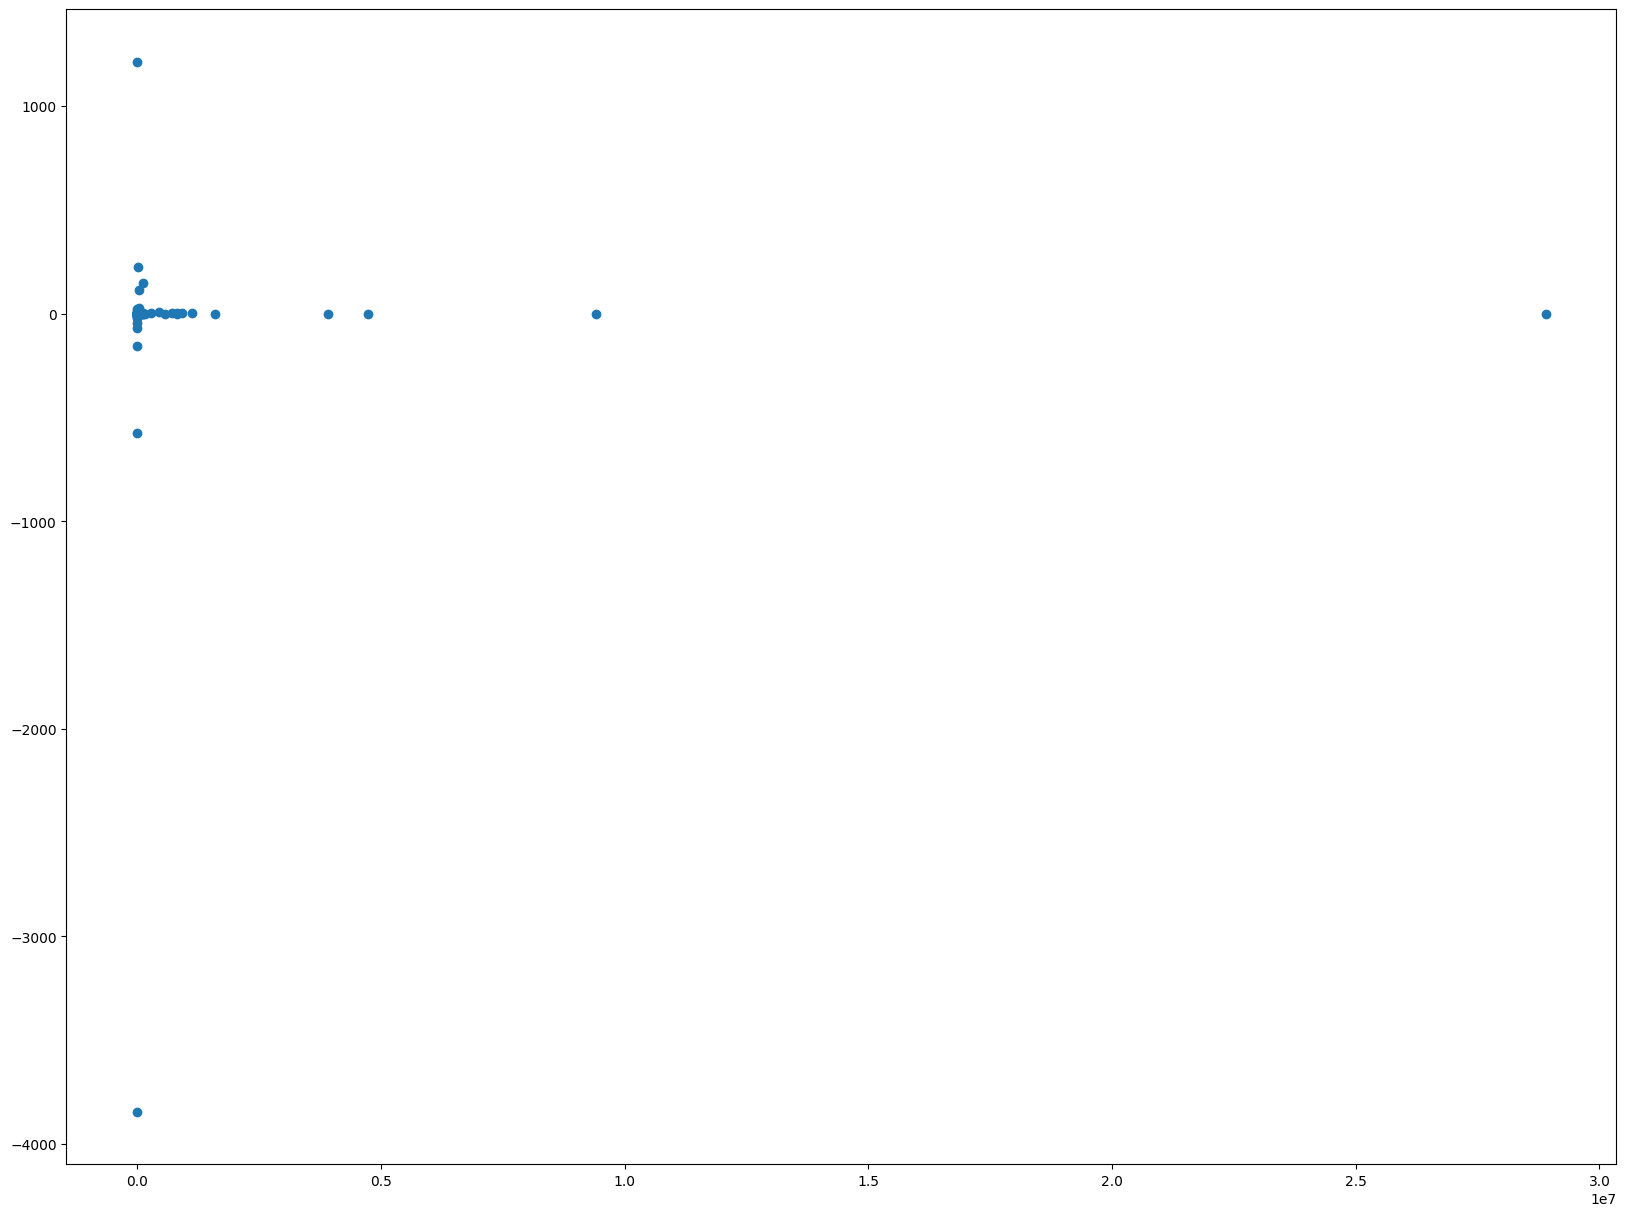

In [22]:
plt.figure(figsize=(20, 15))
plt.scatter(newDF['X'], newDF['Y'])


### Result

I still fail to recreate the data presented in video.
It looks like the data processing procedure is different and created largely different result.

## HW2

### Read and Combine Datasets

In [23]:
data_path_1 = os.path.join(
    os.getcwd().rstrip('src'), 'data', 'TaiwanDeathDetail2021.xlsx')
data_path_2 = os.path.join(
    os.getcwd().rstrip('src'), 'data', 'TaiwanDeathDetail20220611.xlsx')
data1 = pd.read_excel(data_path_1, sheet_name='TaiwanDeathDetail2021.csv')
data2 = pd.read_excel(data_path_2, sheet_name='TaiwanDeathDetail20220611.csv')
data = pd.concat([data1, data2], axis=0)
print(data.shape)
data.head()


(3981, 15)


,公布日,案號,性別,年齡,慢性病史,活動接觸史,發病日,症狀,採檢日,住院/隔離日,確診日,死亡日,日期,是否接種COVID19疫苗,住院／隔離日
0,2022-12-19,4397.0,男,60多歲,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,男,50多歲,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,女,90多歲,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,男,80多歲,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,女,70多歲,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


In [24]:
export_path = os.path.join(
    os.getcwd().rstrip('src'), 'data', 'TaiwanDeathDetail.csv')
data.to_csv(export_path, index=False)


### Convert Mandarin Content to English

#### Test Google API

In [25]:
# https://pypi.org/project/translators/
print(ts.translators_pool)
print(ts.translate_text('我是一個人'))
print(tss.google('食慾不振、昏睡', from_language='zh', to_language='en'))


['alibaba', 'argos', 'baidu', 'bing', 'caiyun', 'deepl', 'google', 'iciba', 'iflytek', 'itranslate', 'lingvanex', 'niutrans', 'mglip', 'papago', 'reverso', 'sogou', 'tencent', 'translateCom', 'utibet', 'yandex', 'youdao']


KeyboardInterrupt: 

#### Test Baidu (Professional Field)
('common','medicine','electronics','mechanics')

In [ ]:
# super unstable
# print(tss.baidu('食慾不振、昏睡', professional_field='medicine'))

#### Rename columns

In [ ]:
# flatten dynamic dimension list
def flatten(lis):
    def flat(lis):
        for element in lis:
            if isinstance(element, list):
                flat(element)
            else:
                return_lis.append(element)
    return_lis = []
    flat(lis)
    return return_lis



In [ ]:
def translate(lis):
    return_lis = []
    for element in lis:
        temp = tss.google(element, from_language='zh', to_language='en')
        temp = temp.lower()
        return_lis.append(temp)
    return return_lis

In [ ]:
# replace '／' with '/'
columns = data.columns.to_list()
columns_tmp = []
for element in columns:
    if '／' in element:
        element = element.replace('／', '/')
    columns_tmp.append(element)
columns = columns_tmp

In [ ]:
# translate
columns_ts = translate(columns)


In [ ]:
# rename columns
print(columns)
print(columns_ts)
data.columns = columns_ts
data.head()

['公布日', '案號', '性別', '年齡', '慢性病史', '活動接觸史', '發病日', '症狀', '採檢日', '住院/隔離日', '確診日', '死亡日', '日期', '是否接種COVID19疫苗', '住院/隔離日']
['announcement day', 'case number', 'gender', 'age', 'chronic medical history', 'activity contact history', 'onset day', 'symptom', 'admission day', 'inpatient/isolation day', 'diagnosis day', 'death day', 'date', 'whether to vaccinate the covid19 vaccine', 'inpatient/isolation day']


,announcement day,case number,gender,age,chronic medical history,activity contact history,onset day,symptom,admission day,inpatient/isolation day,diagnosis day,death day,date,whether to vaccinate the covid19 vaccine,inpatient/isolation day
0,2022-12-19,4397.0,男,60多歲,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,男,50多歲,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,女,90多歲,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,男,80多歲,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,女,70多歲,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


#### Translate Column 'gender'

In [ ]:
genders = data['gender'].unique().tolist()
print(genders)
genders_ts = translate(genders)
print(genders_ts)


['男', '女']
['male', 'female']


In [ ]:
map_dict = dict(zip(genders, genders_ts))
print(map_dict)
data['gender'] = data['gender'].map(map_dict)
data.head()

{'男': 'male', '女': 'female'}


,announcement day,case number,gender,age,chronic medical history,activity contact history,onset day,symptom,admission day,inpatient/isolation day,diagnosis day,death day,date,whether to vaccinate the covid19 vaccine,inpatient/isolation day
0,2022-12-19,4397.0,male,60多歲,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,male,50多歲,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,female,90多歲,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,male,80多歲,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,female,70多歲,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


#### Translate Column 'age'

In [ ]:
ages = data['age'].unique().tolist()
print(ages)
ages_ts = []
for element in ages:
    if type(element) == float:
        pass
    else:
        if '多歲' in element:
            element = element.replace('多歲', '+')
        elif '多歲以上' in element:
            element = element.replace('多歲以上', '+')
        elif '未滿' in element:
            element = element.replace('未滿', '')
            element = element.replace('歲', '-')
        elif '以上' in element:
            element = element.replace('以上', '+')
        elif '未滿' in element:
            element = element.replace('未滿', '')
            element = element.replace('歲', '-')
        elif '歲' in element:
            element = element.replace('歲', '')
    ages_ts.append(element)
print(ages_ts)
ages_dict = dict(zip(ages, ages_ts))
print(ages_dict)
data['age'] = data['age'].map(ages_dict)
data.head()


['60多歲', '50多歲', '90多歲', '80多歲', '70多歲', '40多歲', '100多歲', '30多歲', '90多歲以上', '90歲以上', '20多歲', '10多歲', '未滿5歲', '未滿10歲', nan, '102歲', '101歲', '100歲', '98歲', '97歲', '95歲', '94歲', '93歲', '92歲', '91歲', '90歲', '89歲', '88歲', '87歲', '86歲', '85歲', '84歲', '83歲', '82歲', '81歲', '80歲', '79歲', '78歲', '77歲', '76歲', '75歲', '74歲', '73歲', '72歲', '71歲', '70歲', '69歲', '68歲', '67歲', '64歲', '62歲', '61歲', '60歲', '55歲', '48歲', '38歲', '22歲', '4歲', '1歲']
['60+', '50+', '90+', '80+', '70+', '40+', '100+', '30+', '90+以上', '90歲+', '20+', '10+', '5-', '10-', nan, '102', '101', '100', '98', '97', '95', '94', '93', '92', '91', '90', '89', '88', '87', '86', '85', '84', '83', '82', '81', '80', '79', '78', '77', '76', '75', '74', '73', '72', '71', '70', '69', '68', '67', '64', '62', '61', '60', '55', '48', '38', '22', '4', '1']
{'60多歲': '60+', '50多歲': '50+', '90多歲': '90+', '80多歲': '80+', '70多歲': '70+', '40多歲': '40+', '100多歲': '100+', '30多歲': '30+', '90多歲以上': '90+以上', '90歲以上': '90歲+', '20多歲': '20+', '10多歲': '10+', '未滿5歲':

,announcement day,case number,gender,age,chronic medical history,activity contact history,onset day,symptom,admission day,inpatient/isolation day,diagnosis day,death day,date,whether to vaccinate the covid19 vaccine,inpatient/isolation day
0,2022-12-19,4397.0,male,60+,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,male,50+,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,female,90+,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,male,80+,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,female,70+,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


#### Translate Column 'chronic medical history'

In [ ]:
cmhs = data['chronic medical history'].unique().tolist()
print(cmhs)
cmhs_ts = []
for element in cmhs:
    print(f'{element} -> ', end='')
    if type(element) == float:
        pass
    elif element == '--':
        pass
    elif element == '有':
        element = 'yes'
    else:
        element = element.replace('、', ',')
        element = element.replace('，', ',')
        element = element.replace('；', ',')
        element = element.replace(';', ',')
        element = element.replace(' ', '')
        element = element.replace('　', '')
        element = translate(element)[0]
        element = element.lower()
    cmhs_ts.append(element)
    print(element, end='\r')
print(cmhs_ts)

['有', '--', nan, '無', '調查中', '糖尿病、慢性阻塞性肺疾病、心臟病', '糖尿病、高血壓、心臟病', '帶狀疱疹、慢性阻塞性肺病', '癌症', '中風', '糖尿病、高血壓', '冠狀動脈疾病', '糖尿病、心臟病', '心臟病、腦中風', '高血壓、中風', '高血壓、高血脂、心臟病、腎臟病', '慢性肝炎', '糖尿病、腎臟病、心臟病', '高血壓、心臟病', '高血壓、糖尿病、心律不整、氣喘', '高血壓、糖尿病', '腦中風', '高血壓、糖尿病、高血脂', '心臟病、腎臟病', '高血壓、心臟病、糖尿病', '慢性阻塞性肺病、腎臟病、腦中風', '高血壓、腦中風', '冠狀動脈疾病、糖尿病、高血壓', '高血壓疾病', '癌症、心臟病', '糖尿病、慢性阻塞性肺疾病、慢性肝 炎、氣喘', '慢性腎臟病、癌症', '慢性腎臟病、糖尿病、高血壓', '氣喘、冠狀動脈疾病、慢性腎臟病', '高血壓', '心臟病、心臟衰竭', '糖尿病、慢性阻塞、性肺病', '心臟病', '糖尿病', '心臟病、糖尿病', '高血壓性心臟病', '高血壓疾病、氣喘', '高血壓性心臟病、糖尿病', '心血管疾病', '癌症、糖尿病、心衰竭、肋膜積水', '高血壓、糖尿病、惡性腫瘤、心臟病', '糖尿病、惡性腫瘤、痛風、肝硬化', '肺結核、腎臟病', '高血壓、痛風、腎臟病', '心臟病、慢性阻塞性肺病、糖尿病', '糖尿病、高血壓、心律不整', '高血壓、慢性阻塞性肺病、癌症', '心血管疾病、慢性阻塞性肺病', '高血壓、中風、腎臟病、癌症', '糖尿病、高血壓、高血脂', '腎臟病、心臟病', '冠狀動脈疾病、慢性阻塞性肺病', '不明', '高血壓、腦中風、腎臟病', '高血壓、慢性阻塞性肺病', '心血管疾病、腦梗塞、高血脂', '糖尿病、腎臟病變、高血壓、心臟病、高血脂', '高血壓、高血脂症、腦中風', '洗腎、高血壓、糖尿病、痛風性腎病', '慢性阻塞性肺病、腦血管疾病、腎臟', '高血壓、糖尿病、腎臟病', '糖尿病、腎臟病', '高血壓、心臟病、腎臟病', '慢性腎臟病、心臟病、糖尿病、肺功能不佳', '洗腎、心臟病', '糖尿病、高血壓、哮喘', '高血壓、糖尿病及心臟病', '高血壓、高血脂、糖尿病', '主動脈剝離病史', '

KeyboardInterrupt: 

In [ ]:
# # translator module failed to translate
# print(cmhs_ts)
# cmhs_dict = dict(zip(cmhs, cmhs_ts))
# print(cmhs_dict)
# data['chronic medical history'] = data['chronic medical history'].map(cmhs_dict)
# data.head()

#### Translate Column 'activity contact history'

In [ ]:
achs = data['activity contact history'].unique().tolist()
print(achs)
achs_ts = []
for element in achs:
    print(f'{element} -> ', end='')
    try:
        if type(element) == float:
            pass
        elif element == '--':
            pass
        elif element == '有':
            element = 'yes'
        elif element == '無':
            element = 'no'
        else:
            element = element.replace('、', ',')
            element = element.replace('，', ',')
            element = element.replace('；', ',')
            element = element.replace(';', ',')
            element = element.replace(' ', '')
            element = element.replace('　', '')
            element = translate(element)[0]
            element = element.lower()
    except:
        print('error element: ', element)
    achs_ts.append(element)
    print(element, end='\r')
print(achs_ts)

['無', '有', '接觸其他確診者', '萬華活動史', '--', '8月6日自越南入境', '萬華區活動史', nan, '相關活動接觸史', '接觸其他確診案', '調查中', '接觸其他確診個案', '4/11境外移入', '菲律賓回台', '緬甸回台', '境外移入（英國變種病毒）']
['no', 'yes', 'catch', 'ten thousand', '--', '8', 'ten thousand', nan, 'mutually', 'catch', 'tune', 'catch', '4', 'favored', 'myanmar', 'territory']


In [ ]:
# perform really bad
achs_dict = dict(zip(achs, achs_ts))
print(achs_dict)
data['activity contact history'] = data['activity contact history'].map(achs_dict)
data.head()

{'無': 'no', '有': 'yes', '接觸其他確診者': 'catch', '萬華活動史': 'ten thousand', '--': '--', '8月6日自越南入境': '8', '萬華區活動史': 'ten thousand', nan: nan, '相關活動接觸史': 'mutually', '接觸其他確診案': 'catch', '調查中': 'tune', '接觸其他確診個案': 'catch', '4/11境外移入': '4', '菲律賓回台': 'favored', '緬甸回台': 'myanmar', '境外移入（英國變種病毒）': 'territory'}


,announcement day,case number,gender,age,chronic medical history,activity contact history,onset day,symptom,admission day,inpatient/isolation day,diagnosis day,death day,date,whether to vaccinate the covid19 vaccine,inpatient/isolation day
0,2022-12-19,4397.0,male,60+,有,no,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,male,50+,有,yes,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,female,90+,有,yes,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,male,80+,有,catch,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,female,70+,有,catch,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


#### Translate Column 'symptom'

In [ ]:
def DataFrameColumnTranslator(df, column_name):
    elements = df[column_name].unique().tolist()
    print(elements)
    elements_ts = []
    for element in elements:
        print(f'{element} -> ', end='')
        try:
            if type(element) == float:
                pass
            elif element == '--':
                pass
            elif element == '有':
                element = 'yes'
            elif element == '無':
                element = 'no'
            else:
                element = element.replace('、', ',')
                element = element.replace('，', ',')
                element = element.replace('；', ',')
                element = element.replace(';', ',')
                element = element.replace(' ', '')
                element = element.replace('　', '')
                element = translate(element)[0]
                element = element.lower()
        except:
            print('error element: ', element)
        elements_ts.append(element)
        print(element, end='\r')
    print(elements_ts)
    elements_dict = dict(zip(elements, elements_ts))
    print(elements_dict)
    df[column_name] = df[column_name].map(elements_dict)
    return df

In [ ]:
# # skipped / unknown reason
# iids = data['inpatient/isolation day'].unique().tolist()
# print(iids)


#### Export

In [ ]:
export_path = os.path.join(
    os.getcwd().rstrip('src'), 'data', 'TaiwanDeathDetail_ts.csv')
data.to_csv(export_path, index=False)